<a href="https://colab.research.google.com/github/vpinilla001/DeepAnT/blob/master/Copia_de_unsupervised_timeseries_anomaly_detection3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data** : **eighty-years-of-canadian-climate-data/Canadian_climate_history.csv**

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_file = "/content/art_daily_nojump.csv"
MODEL_SELECTED = "lstmae" # Possible Values ['deepant', 'lstmae']
LOOKBACK_SIZE = 500 #Ventana temporal de 10 puntos

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def read_modulate_data(data_file):
    """
        Data ingestion : Function to read and formulate the data
    """
    data = pd.read_csv(data_file)
    data.fillna(data.mean(), inplace=True)
    data = data.iloc[:,[0,1]]
    df = data.copy()
    data.set_index("timestamp", inplace=True)
    data.index = pd.to_datetime(data.index)
    return data, df

In [4]:
def data_pre_processing(df):
    """
        Data pre-processing : Function to create data for Model

        X: Ventanas temporales
        Y: Próximo dato de la ventana temporal --> El dato a predecir
        T: Donde acaba cada ventana temporal Xi (fecha)
    """
    try:
        scaled_data = MinMaxScaler(feature_range = (0, 1))
        data_scaled_ = scaled_data.fit_transform(df)
        df.loc[:,:] = data_scaled_
        _data_ = df.to_numpy(copy=True)
        X = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,LOOKBACK_SIZE,df.shape[1]))
        Y = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,df.shape[1]))
        timesteps = []
        for i in range(LOOKBACK_SIZE-1, df.shape[0]-1):
            timesteps.append(df.index[i])
            Y[i-LOOKBACK_SIZE+1] = _data_[i+1]
            for j in range(i-LOOKBACK_SIZE+1, i+1):
                X[i-LOOKBACK_SIZE+1][LOOKBACK_SIZE-1-i+j] = _data_[j]
        return X,Y,timesteps
    except Exception as e:
        print("Error while performing data pre-processing : {0}".format(e))
        return None, None, None

In [5]:
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=LOOKBACK_SIZE, out_channels=16, kernel_size=1)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=1)
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=1)
        self.flatten_layer = torch.nn.Flatten()
        self.dense_1_layer = torch.nn.Linear(16, 40)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.25)
        self.dense_2_layer = torch.nn.Linear(40, DIMENSION)
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)

In [6]:
class LSTMAE(torch.nn.Module):
    """
        Model : Class for LSTMAE model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(LSTMAE, self).__init__()
        self.lstm_1_layer = torch.nn.LSTM(DIMENSION, 128, 1)
        self.dropout_1_layer = torch.nn.Dropout(p=0.2)
        self.lstm_2_layer = torch.nn.LSTM(128, 64, 1)
        self.dropout_2_layer = torch.nn.Dropout(p=0.2)
        self.lstm_3_layer = torch.nn.LSTM(64, 64, 1)
        self.dropout_3_layer = torch.nn.Dropout(p=0.2)
        self.lstm_4_layer = torch.nn.LSTM(64, 128, 1)
        self.dropout_4_layer = torch.nn.Dropout(p=0.2)
        self.linear_layer = torch.nn.Linear(128, DIMENSION)
        
    def forward(self, x):
        x, (_,_) = self.lstm_1_layer(x)
        x = self.dropout_1_layer(x)
        x, (_,_) = self.lstm_2_layer(x)
        x = self.dropout_2_layer(x)
        x, (_,_) = self.lstm_3_layer(x)
        x = self.dropout_3_layer(x)
        x, (_,_) = self.lstm_4_layer(x)
        x = self.dropout_4_layer(x)
        return self.linear_layer(x)

In [7]:
def make_train_step(model, loss_fn, optimizer):
    """
        Computation : Function to make batch size data iterator
    """
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [8]:
def compute(X,Y):
    """
        Computation : Find Anomaly using model based computation 
    """
    if str(MODEL_SELECTED) == "lstmae":
        model = LSTMAE(10,1)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(X.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(15):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        loss = np.linalg.norm(hypothesis - X, axis=(1,2))
        return loss.reshape(len(loss),1)
    elif str(MODEL_SELECTED) == "deepant":
        model = DeepAnT(LOOKBACK_SIZE,1)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(Y.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer)
        for epoch in range(50):
            loss_sum = 0.0
            ctr = 0
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch)
                loss_sum += loss_train
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        # plt.plot(hypothesis)
        loss = np.linalg.norm(hypothesis - Y, axis=1)
        plt.plot(loss)
        return loss.reshape(len(loss),1)
    else:
        print("Selection of Model is not in the set")
        return None

In [ ]:
data, _data = read_modulate_data(data_file)
X,Y,T = data_pre_processing(data)
loss = compute(X, Y)

Training Loss: 0.2621121745523032 - Epoch: 1
Training Loss: 0.23684451423652536 - Epoch: 2
Training Loss: 0.2103269624079133 - Epoch: 3
Training Loss: 0.1828297456843896 - Epoch: 4
Training Loss: 0.16204506252800022 - Epoch: 5
Training Loss: 0.1509744567914052 - Epoch: 6
Training Loss: 0.1370862340470692 - Epoch: 7
Training Loss: 0.11487669934023607 - Epoch: 8
Training Loss: 0.09876807077645182 - Epoch: 9
Training Loss: 0.08906850195280067 - Epoch: 10
Training Loss: 0.08000196140628678 - Epoch: 11
Training Loss: 0.07136872644024389 - Epoch: 12
Training Loss: 0.06528000063724346 - Epoch: 13
Training Loss: 0.06168034281749446 - Epoch: 14
Training Loss: 0.05871033312769623 - Epoch: 15


In [ ]:
loss_df = pd.DataFrame(loss, columns = ["loss"])
loss_df.index = T
loss_df.index = pd.to_datetime(loss_df.index)
loss_df["timestamp"] = T
loss_df["timestamp"] = pd.to_datetime(loss_df["timestamp"])

In [ ]:
"""
    Visualization 
"""
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
data1 = pd.read_csv(data_file)
data1['timestamp'] = pd.to_datetime(data1['timestamp'],format= '%Y-%m-%d %H:%M:%S')
anomalies = data1.loc[data1['label'] == 1, ['timestamp', 'value']]

plt.plot(data1['timestamp'], data1['value'])
plt.scatter(anomalies['timestamp'],anomalies['value'], color='red', label = 'Anomaly')


plt.figure(figsize=(20,10))
ax = sns.lineplot(x="timestamp", y="loss", data=loss_df, color='g', label="Anomaly Score")
ax.set_title("Anomaly Confidence Score vs Timestamp")
ax.set(ylabel="Anomaly Confidence Score", xlabel="Timestamp")
plt.legend()

In [ ]:
scaled_data = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaled_data.fit_transform(loss_df[['loss']])

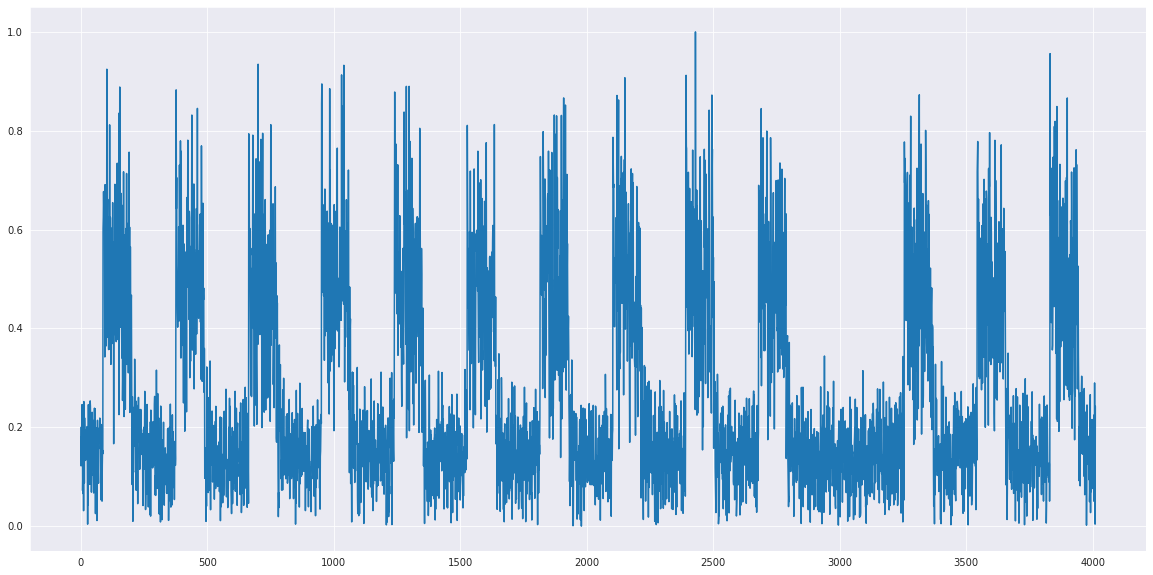

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data_scaled)

In [ ]:
df_scaled = pd.DataFrame(data_scaled)

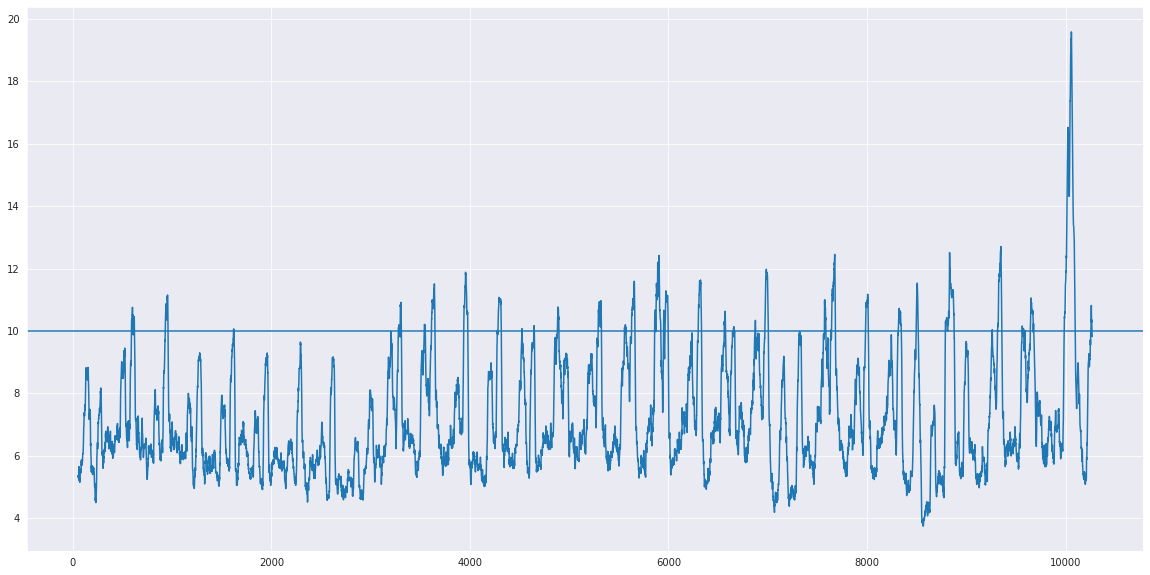

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df_scaled.rolling(50).sum())
plt.axhline(y=10)

In [ ]:
data

,value
timestamp,
2014-07-01 00:00:00,0.276506
2014-07-01 00:30:00,0.207175
2014-07-01 01:00:00,0.158259
2014-07-01 01:30:00,0.118605
2014-07-01 02:00:00,0.097272
...,...
2015-01-31 21:30:00,0.629309
2015-01-31 22:00:00,0.656128
2015-01-31 22:30:00,0.696650


In [ ]:
!pip install saxpy

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 235kB 7.4MB/s 
  Created wheel for saxpy: filename=saxpy-1.0.1.dev167-cp36-none-any.whl size=17671 sha256=48a12d534138d6367e30ad8cea0afef9dbbafc32e3b5071e694884bda73b3f88
  Stored in directory: /root/.cache/pip/wheels/68/d1/a0/a2a4f96eb82607654bc45f00479af34ddd7c45be9096b8e63c
Successfully built saxpy
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.2.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.2.1 which is incompatible.
ERROR: pytest-cov 2.10.0 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [ ]:
import numpy as np
from saxpy.hotsax import find_discords_hotsax
from numpy import genfromtxt
# dd = genfromtxt("/content/repsol.csv", delimiter=',')  
discords = find_discords_hotsax(np.array(data.iloc[:,0]), num_discords=4)
discords

[(10049, 7.855248985710178),
 (8781, 6.2277343522257045),
 (5900, 4.106825785511726),
 (122, 4.083627397296858)]

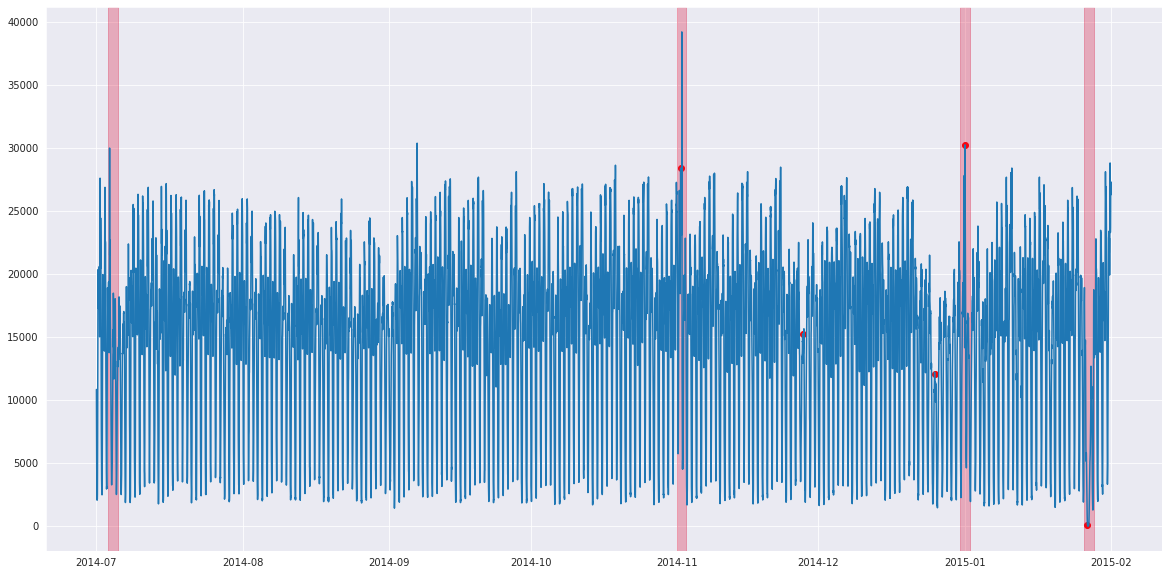

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
data1 = pd.read_csv(data_file)
data1['timestamp'] = pd.to_datetime(data1['timestamp'],format= '%Y-%m-%d %H:%M:%S')
anomalies = data1.loc[data1['label'] == 1, ['timestamp', 'value']]

plt.plot(data1['timestamp'], data1['value'])
plt.scatter(anomalies['timestamp'],anomalies['value'], color='red', label = 'Anomaly')
plt.axvspan(data1['timestamp'][122], data1['timestamp'][122+100], color="crimson", alpha=0.3)
plt.axvspan(data1['timestamp'][5900], data1['timestamp'][5900+100], color="crimson", alpha=0.3)
plt.axvspan(data1['timestamp'][8781], data1['timestamp'][8781+100], color="crimson", alpha=0.3)
plt.axvspan(data1['timestamp'][10049], data1['timestamp'][10049+100], color="crimson", alpha=0.3)

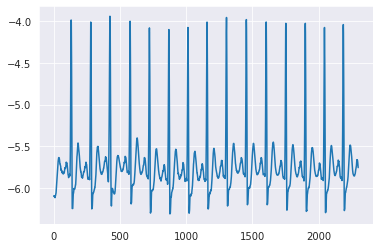

In [ ]:
plt.plot(dd)

In [1]:
!pip install luminol

In [31]:
import luminol
import pandas as pd
import numpy as np

from luminol import anomaly_detector
import matplotlib.pyplot as plt

In [18]:
data_file = '/content/art_daily_nojump.csv'
data = pd.read_csv(data_file)
data.fillna(data.mean(), inplace=True)

In [19]:
ts = dict(zip(data.index, data.value))

In [20]:
len(ts)*0.02

80.64

In [45]:
detector = luminol.anomaly_detector.AnomalyDetector(ts, algorithm_name='bitmap_detector', algorithm_params=
                                                    {'precision':4, 'lag_window_size':100, 'future_window_size':100, 'chunk_size':10})
anomalies = detector.get_all_scores()

In [46]:
anom = []
for (timestamp, value) in anomalies.iteritems():
  anom.append(value)

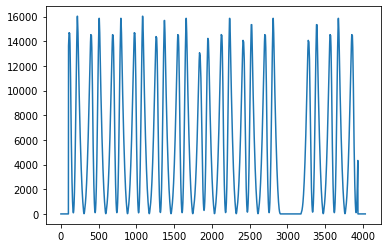

In [47]:
plt.plot(anom)